# Free Falling Object

In this notebook, we will simulate the falling of an object due to gravity, with no initial velocity or external forces applied to it.

## Imports

In [1]:
using OrdinaryDiffEq
using DiffEqCallbacks
using Plots

## Equation of motion

The equation of motion for an object falling freely in a gravitational field is:
$$
    \frac{d^2 x}{d t^2} = - g
$$
where $g$ is the acceleration due to Earth's gravity, which we will approximate as $g \approx 9.81 \frac{m}{s^2}$ (taken with a minus sign because we're considering positive $x$ to be upwards).

In [2]:
g = 9.81

function free_falling_object!(d²x, dx, x, p, t)
    @. d²x = -g
end

free_falling_object! (generic function with 1 method)

In [3]:
initial_height = 10.0
time_interval = (0.0, 15.0)

prob = SecondOrderODEProblem(free_falling_object!,
    [0.0], [initial_height],
    time_interval)

ODEProblem with uType RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 15.0)
u0: ([0.0], [10.0])

### Callbacks

We are now going to define a series of continuous callbacks (events) and discrete callbacks, in order to add additional behavior to the simulation.

#### Ground collision callback

We will implement a continuous callback for detecting when the ball hits the ground. In this case, we'll flip its velocity and decrease it by a certain friction coefficient.

After the ball has hit the ground a few times and lost most of its kinetic energy, we'll want to stop the simulation to avoid having it fall through the Earth 😱 (due to numerical errors).

In [4]:
friction_coefficient = 0.75

function ball_hitting_the_ground_condition(u, t, integrator)
    dx, x = u
    x
end

function ball_hitting_the_ground_affect!(integrator)
    integrator.u[1] = -integrator.u[1] * friction_coefficient

    # If we're taking some big timesteps
    if integrator.dt > 1e-10
        # Reduce the timestep considerably
        previous_dt = integrator.t - integrator.tprev
        set_proposed_dt!(integrator, previous_dt / 10)
    else
        # Stop the ball to avoid it going through the floor
        integrator.u[1] = dx = 0
        integrator.u[2] = x = 0
        terminate!(integrator)
    end
end

ground_hit_callback = ContinuousCallback(ball_hitting_the_ground_condition, ball_hitting_the_ground_affect!);

#### Ball kick callback

Now we'll add a discrete callback to simulate the kicking of the ball at a certain timestamp. This is implemented as an instantaneous increase of the ball's velocity.

In [5]:
ball_kicking_time = 4
ball_kicking_Δv = 7

function ball_kicking_affect!(integrator)
    integrator.u[1] += ball_kicking_Δv
end

ball_kicking_callback = PresetTimeCallback(ball_kicking_time, ball_kicking_affect!);

#### Composing all of the callbacks together

In [6]:
callback_set = CallbackSet(ground_hit_callback, ball_kicking_callback);

### Solving the problem

In [7]:
sol = solve(prob, DPRKN12(), callback = callback_set);
println("Solution terminated with return code `$(sol.retcode)`")
println("Solution length: $(length(sol)) savepoints")

Solution terminated with return code `Terminated`
Solution length: 346 savepoints


### Plotting the result

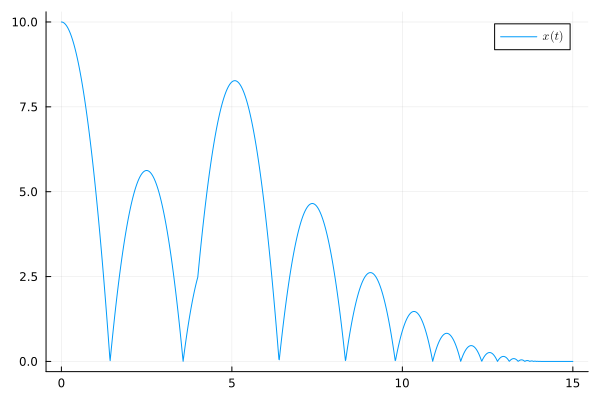

In [8]:
time_axis = range(time_interval[1], time_interval[2], step = 0.01)

plot(t -> sol(t)[2], time_axis, label = "\$x \\, (t)\$")
# plot!(t -> sol(t)[1], time_axis, label = "\$\\dot{x} \\, (t)\$")